In [1]:
import nest_asyncio
nest_asyncio.apply()
import multiprocessing
multiprocessing.set_start_method("fork")
import pandas as pd
import stan
import numpy as np
from scipy.stats import pearsonr

from scipy.special import expit
import matplotlib.pyplot as plt
import arviz as az

# Emma notes (8/22):

In general, let's build complexity iteratively. Start by getting reasonable results without worrying about ICAR prior/smoothing. Then use standard ICAR prior (with weight 0.5). Then use full CAR (maybe). Data generation code is reviewed + model without proper CAR prior is reviewed. 

Model with simple L2 smoothing (or no smoothing at all - stan_code_with_weighted_ICAR_prior):

1. Consistently recovers parameters for realistic parameter settings (with no smoothing)
2. Reviewed Stan code and looks good. 
3. ALso implemented L2 regularization for adjacent Census tracts. This isn't actually the "proper" way to do it, but might be useful on real data. Haven't tested how this performs. 

Model wih full CAR prior (stan_code_proper_car_prior):

1. Haven't reviewed this or verified it recovers correct params (recently; I think I did a while ago). When you do review, don't need to re-review all the Bayesian conditioning math; it should be pretty similar to the old code. 


In [10]:
# Stan code with CAR prior seems to work but hasn't been reviewed. 
# CAR prior is https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
stan_code_proper_car_prior = '''
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha,
                       array[,] int W_sparse, vector D_sparse, vector lambda,
                       int n, int W_n) {
    row_vector[n] phit_D; // phi' * D
    row_vector[n] phit_W; // phi' * W
    vector[n] ldet_terms;
    
    phit_D = (phi .* D_sparse)';
    phit_W = rep_row_vector(0, n);
    for (i in 1 : W_n) {
      phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
      phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
    }
    
    for (i in 1 : n) {
      ldet_terms[i] = log1m(alpha * lambda[i]);
    }
    return 0.5
           * (n * log(tau) + sum(ldet_terms)
              - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}

data {
  int<lower=0> N;
  int<lower=0> N_edges;
  matrix<lower=0, upper=1>[N, N] W; // adjacency matrix
  int W_n; // number of adjacent region pairs
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
transformed data {
  array[W_n, 2] int W_sparse; // adjacency pairs
  vector[N] D_sparse; // diagonal of D (number of neigbors for each site)
  vector[N] lambda; // eigenvalues of invsqrtD * W * invsqrtD
  
  {
    // generate sparse representation for W
    int counter;
    counter = 1;
    // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1 : (N - 1)) {
      for (j in (i + 1) : N) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1 : N) {
    D_sparse[i] = sum(W[i]);
  }
  {
    vector[N] invsqrtD;
    for (i in 1 : N) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}

parameters {
  vector[N] phi;
  real<lower=0> tau;
  real<lower=0, upper=1> alpha;
  real <upper=0>phi_offset; // you may not want to place this constraint but it helps convergence with small numbers of samples
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative , p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  tau ~ gamma(2, 2);
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, N, W_n);
  phi_offset ~ normal(-4, 0.5);
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

# Stan code below works and has been reviewed but does not implement a proper ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all. 
# I think it might also be principled to set the ICAR prior weight to 0.5, https://mc-stan.org/users/documentation/case-studies/icar_stan.html. 
stan_code_with_weighted_ICAR_prior = '''
data {
  int<lower=0> N; // number of Census tracts. 
  int<lower=0> N_edges; // number of edges in the graph (i.e. number of pairs of adjacent Census tracts). 
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; // vector with one entry per Census tract of the number of images in that tract. 
  array[N] int<lower=0> n_classified_positive; // vector with one entry per Census tract of number of images classified positive. 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real<upper=0> phi_offset; // this is the mean from which phis are drawn. Upper bound at 0 to rule out bad modes and set prior that true positives are rare. 
  ordered[2] logit_p_y_1_given_y_hat; // ordered to impose the constraint that p_y_1_given_y_hat_0 < p_y_1_given_y_hat_1.
}
transformed parameters {
    real p_y_1_given_y_hat_0 = inv_logit(logit_p_y_1_given_y_hat[1]);
    real p_y_1_given_y_hat_1 = inv_logit(logit_p_y_1_given_y_hat[2]);
    vector[N] p_y = inv_logit(phi);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  // You can't just scale ICAR priors by random numbers; the only principled value for ICAR_prior_weight is 0.5. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  // still, there's no computational reason you can't use another value. 
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }

  // model the results on the annotation set. 
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // model the results by Census tract. 
  phi_offset ~ normal(0, 2);
  phi ~ normal(phi_offset, 1); 
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

empirical_p_y 0.28657609206153156
empirical_p_yhat 0.16555247111585436
p_y_hat_1_given_y_1 0.5454261760783528
p_y_hat_1_given_y_0 0.013393799347646361
p_y_1_given_y_hat_1 0.9441484080247612
p_y_1_given_y_hat_0 0.15611525650646277
number of annotated classified negative which were positive: 81/500
number of annotated classified positive which were positive: 471/500
Building...

In file included from /Users/emmapierson/Library/Caches/httpstan/4.12.0/models/ehscsogf/model_ehscsogf.cpp:2:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/httpstan/include/Eigen/SparseCore:61:
/User

9 warnings generated.

Building: 9.6s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (402/12000)
Sampling:   5% (601/12000)
Sampling:   6% (701/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2200/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3400/12000)
Sampling:  30% (3600/12000)
Sampling:  31% (3700/12000)
Sampling:  32% (3900/12000)
Sampling:  34% (4100/12000)
Sampling:  36% (4300/12000)
Sampling:  38% (4500/12000)
Sampling:  39% (4700/12000)
Sampling:  40% (4800/12000)
Sampling:  42% (5000/12000)
Sampling:  44% (5300/12000)
Sampling:  46% (5500/12000)
Sampling:  48%

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.538  0.011   0.517    0.560      0.001    0.001   
p_y_hat_1_given_y_0  0.012  0.001   0.009    0.014      0.000    0.000   
phi_offset          -1.062  0.049  -1.154   -0.969      0.005    0.003   
p_y_1_given_y_hat_1  0.949  0.006   0.938    0.960      0.000    0.000   
p_y_1_given_y_hat_0  0.162  0.008   0.148    0.176      0.001    0.001   
empirical_p_yhat     0.166  0.000   0.166    0.166      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      70.0     152.0   1.03  
p_y_hat_1_given_y_0     345.0     992.0   1.01  
phi_offset              102.0     280.0   1.02  
p_y_1_given_y_hat_1     271.0     945.0   1.01  
p_y_1_given_y_hat_0      66.0     134.0   1.04  
empirical_p_yhat       4000.0    4000.0    NaN  


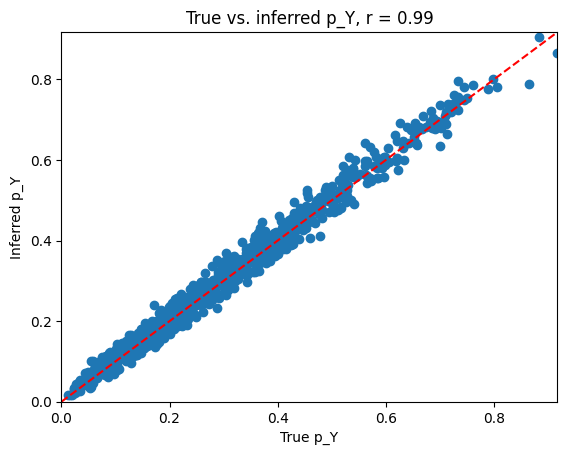

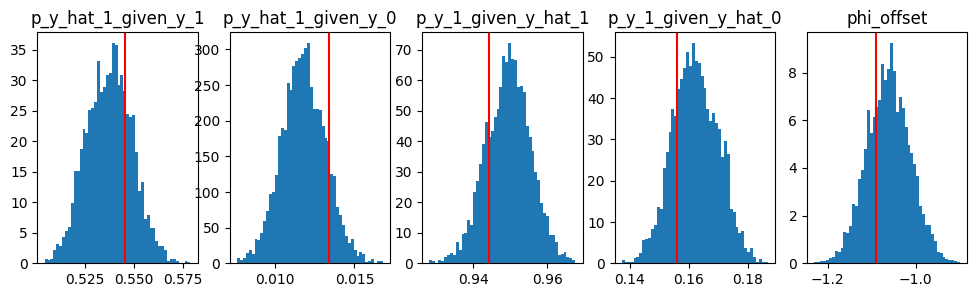

empirical_p_y 0.2124781910949719
empirical_p_yhat 0.10937228325495785
p_y_hat_1_given_y_1 0.46736037948741643
p_y_hat_1_given_y_0 0.01198925516294003
p_y_1_given_y_hat_1 0.9079438141696142
p_y_1_given_y_hat_0 0.12707251407540035
number of annotated classified negative which were positive: 58/500
number of annotated classified positive which were positive: 449/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  29% (3500/12000)
Sampling:  31% (3700/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  37% (4400/12000)
Sampling:  38% (4500/12000)
Sampling:  39% (4700/12000)
Sampling:  41% (4900/12000)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.504  0.020   0.465    0.541      0.002    0.002   
p_y_hat_1_given_y_0  0.012  0.001   0.010    0.014      0.000    0.000   
phi_offset          -1.678  0.068  -1.802   -1.550      0.008    0.005   
p_y_1_given_y_hat_1  0.911  0.007   0.897    0.924      0.000    0.000   
p_y_1_given_y_hat_0  0.110  0.009   0.094    0.128      0.001    0.001   
empirical_p_yhat     0.109  0.000   0.109    0.109      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      65.0     105.0   1.04  
p_y_hat_1_given_y_0     580.0    1674.0   1.00  
phi_offset               82.0     165.0   1.03  
p_y_1_given_y_hat_1     355.0    1348.0   1.01  
p_y_1_given_y_hat_0      64.0     104.0   1.04  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


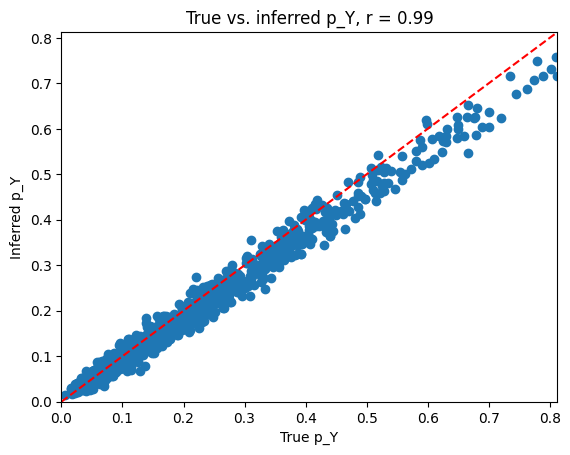

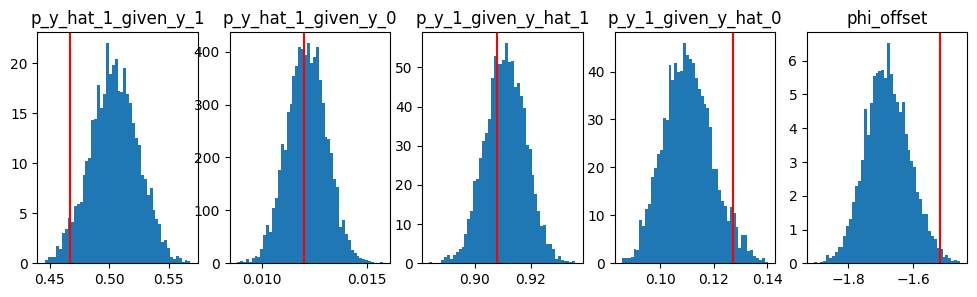

empirical_p_y 0.05990238663867028
empirical_p_yhat 0.05642921829168603
p_y_hat_1_given_y_1 0.6946552158423709
p_y_hat_1_given_y_0 0.015882300240431607
p_y_1_given_y_hat_1 0.7374106283887591
p_y_1_given_y_hat_0 0.019384747464939924
number of annotated classified negative which were positive: 8/500
number of annotated classified positive which were positive: 383/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.713  0.062   0.604    0.833      0.010    0.007   
p_y_hat_1_given_y_0  0.016  0.001   0.015    0.017      0.000    0.000   
phi_offset          -3.196  0.103  -3.395   -3.011      0.016    0.011   
p_y_1_given_y_hat_1  0.727  0.009   0.710    0.745      0.000    0.000   
p_y_1_given_y_hat_0  0.018  0.005   0.008    0.028      0.001    0.001   
empirical_p_yhat     0.056  0.000   0.056    0.056      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      37.0      47.0   1.08  
p_y_hat_1_given_y_0    1067.0    2376.0   1.00  
phi_offset               43.0      70.0   1.07  
p_y_1_given_y_hat_1     528.0    1334.0   1.00  
p_y_1_given_y_hat_0      37.0      47.0   1.08  
empirical_p_yhat       4000.0    4000.0    NaN  


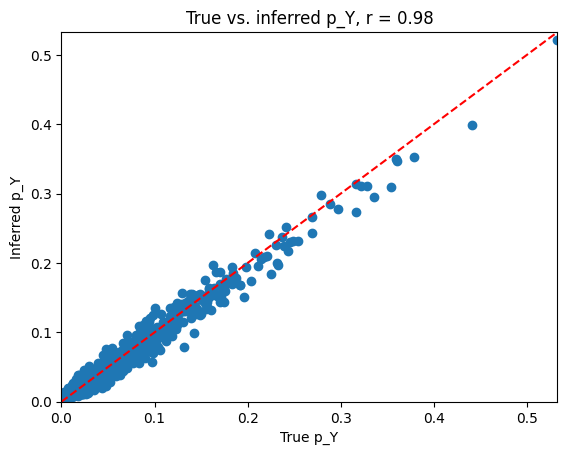

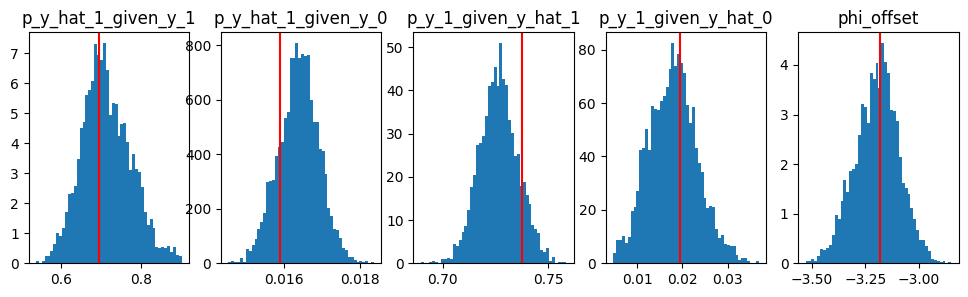

empirical_p_y 0.2922095974495337
empirical_p_yhat 0.15591205371339656
p_y_hat_1_given_y_1 0.5084292912562012
p_y_hat_1_given_y_0 0.010739853844731372
p_y_1_given_y_hat_1 0.9528956548967626
p_y_1_given_y_hat_0 0.170173830288574
number of annotated classified negative which were positive: 76/500
number of annotated classified positive which were positive: 477/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (401/12000)
Sampling:   5% (601/12000)
Sampling:   6% (701/12000)
Sampling:   7% (800/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2200/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  29% (3500/12000)
Sampling:  32% (3800/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  37% (4400/12000)
Sampling:  38% (4600/12000)
Sampling:  40% (4800/12000)
Sampling:  42% (5100/12000)
Sampling:  44% (5300/12000)
Sampling:  56% (6700/12000)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.522  0.014   0.496    0.547      0.002    0.001   
p_y_hat_1_given_y_0  0.010  0.001   0.008    0.013      0.000    0.000   
phi_offset          -1.105  0.056  -1.217   -1.008      0.006    0.004   
p_y_1_given_y_hat_1  0.953  0.007   0.940    0.965      0.000    0.000   
p_y_1_given_y_hat_0  0.161  0.009   0.144    0.178      0.001    0.001   
empirical_p_yhat     0.156  0.000   0.156    0.156      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      64.0      98.0   1.06  
p_y_hat_1_given_y_0     291.0    1054.0   1.00  
phi_offset               83.0     184.0   1.04  
p_y_1_given_y_hat_1     231.0     818.0   1.01  
p_y_1_given_y_hat_0      61.0     102.0   1.06  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


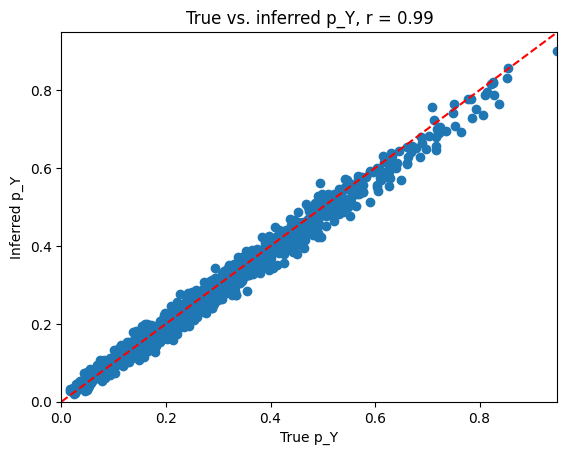

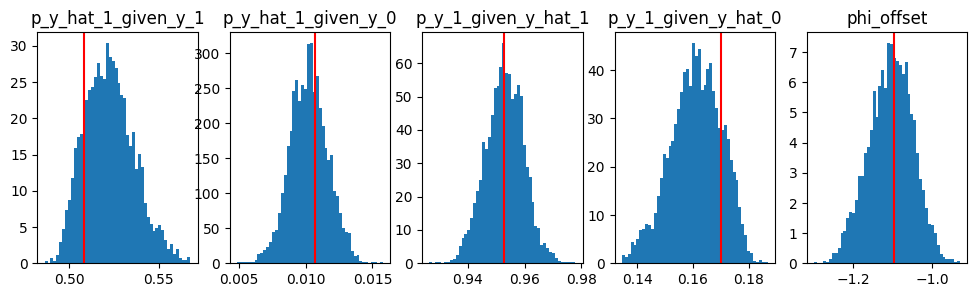

empirical_p_y 0.03081520972920331
empirical_p_yhat 0.0315591182284579
p_y_hat_1_given_y_1 0.6916944978769821
p_y_hat_1_given_y_0 0.01048617423007098
p_y_1_given_y_hat_1 0.6753899417061341
p_y_1_given_y_hat_0 0.00981009671050765
number of annotated classified negative which were positive: 3/500
number of annotated classified positive which were positive: 335/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (302/12000)
Sampling:   3% (401/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)


                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.846  0.062   0.742    0.962      0.012    0.009   
p_y_hat_1_given_y_0  0.010  0.000   0.010    0.011      0.000    0.000   
phi_offset          -4.129  0.089  -4.287   -3.957      0.016    0.011   
p_y_1_given_y_hat_1  0.680  0.010   0.660    0.699      0.000    0.000   
p_y_1_given_y_hat_0  0.004  0.002   0.001    0.007      0.000    0.000   
empirical_p_yhat     0.032  0.000   0.032    0.032      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      25.0      64.0   1.11  
p_y_hat_1_given_y_0    1160.0    2040.0   1.00  
phi_offset               31.0     118.0   1.09  
p_y_1_given_y_hat_1     930.0    1899.0   1.00  
p_y_1_given_y_hat_0      25.0      61.0   1.11  
empirical_p_yhat       4000.0    4000.0    NaN  


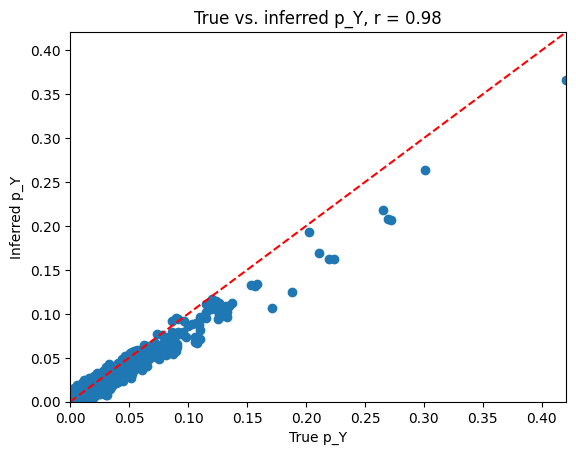

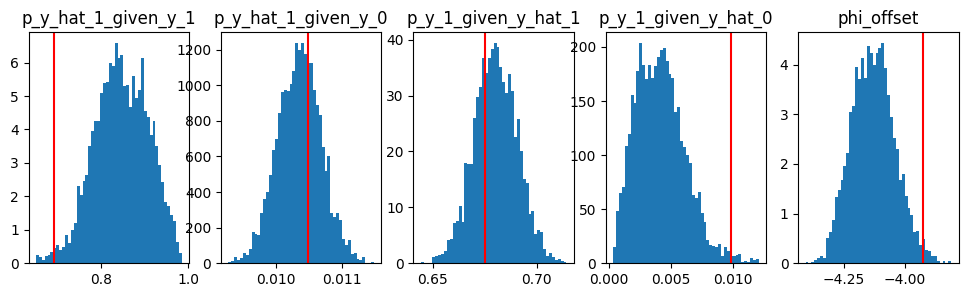

empirical_p_y 0.1918849703355299
empirical_p_yhat 0.08374130739919787
p_y_hat_1_given_y_1 0.3675639403278412
p_y_hat_1_given_y_0 0.016532562703470817
p_y_1_given_y_hat_1 0.8422366210501016
p_y_1_given_y_hat_0 0.1324461918116654
number of annotated classified negative which were positive: 64/500
number of annotated classified positive which were positive: 425/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   3% (302/12000)
Sampling:   3% (401/12000)
Sampling:   4% (500/12000)
Sampling:   6% (700/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  26% (3100/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  30% (3600/12000)
Sampling:  32% (3800/12000)
Sampling:  32% (3900/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  37% (4400/1200

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.366  0.019   0.334    0.402      0.003    0.002   
p_y_hat_1_given_y_0  0.017  0.001   0.015    0.018      0.000    0.000   
phi_offset          -1.704  0.084  -1.853   -1.548      0.012    0.009   
p_y_1_given_y_hat_1  0.839  0.010   0.821    0.857      0.001    0.001   
p_y_1_given_y_hat_0  0.134  0.011   0.113    0.154      0.002    0.001   
empirical_p_yhat     0.084  0.000   0.084    0.084      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      42.0     140.0   1.08  
p_y_hat_1_given_y_0     238.0    1161.0   1.02  
phi_offset               48.0     188.0   1.07  
p_y_1_given_y_hat_1     114.0     862.0   1.04  
p_y_1_given_y_hat_0      41.0     121.0   1.09  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


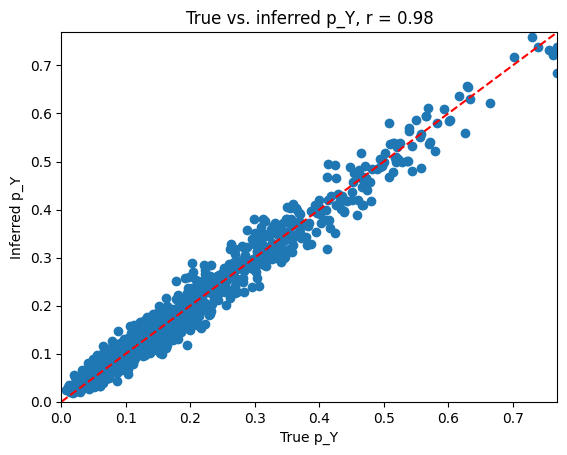

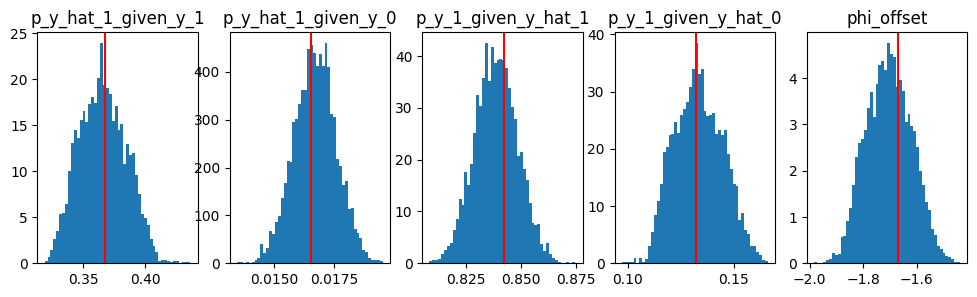

empirical_p_y 0.08806653671630983
empirical_p_yhat 0.06351232011393493
p_y_hat_1_given_y_1 0.5865805731190066
p_y_hat_1_given_y_0 0.013253939089589432
p_y_1_given_y_hat_1 0.8133558888573023
p_y_1_given_y_hat_0 0.038877625321328615
number of annotated classified negative which were positive: 17/500
number of annotated classified positive which were positive: 396/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   3% (302/12000)
Sampling:   3% (401/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  24% (2900/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  30% (3600/12000)
Sampling:  31% (3700/12000)
Sampling:  32% (3900/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  37% (4400/12000)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.602  0.046   0.523    0.686      0.011    0.008   
p_y_hat_1_given_y_0  0.013  0.001   0.012    0.014      0.000    0.000   
phi_offset          -2.743  0.096  -2.915   -2.569      0.022    0.016   
p_y_1_given_y_hat_1  0.809  0.008   0.793    0.825      0.001    0.000   
p_y_1_given_y_hat_0  0.037  0.007   0.025    0.050      0.002    0.001   
empirical_p_yhat     0.064  0.000   0.064    0.064      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      18.0      90.0   1.16  
p_y_hat_1_given_y_0     891.0    2290.0   1.01  
phi_offset               19.0     124.0   1.15  
p_y_1_given_y_hat_1     272.0    1164.0   1.02  
p_y_1_given_y_hat_0      18.0      87.0   1.17  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


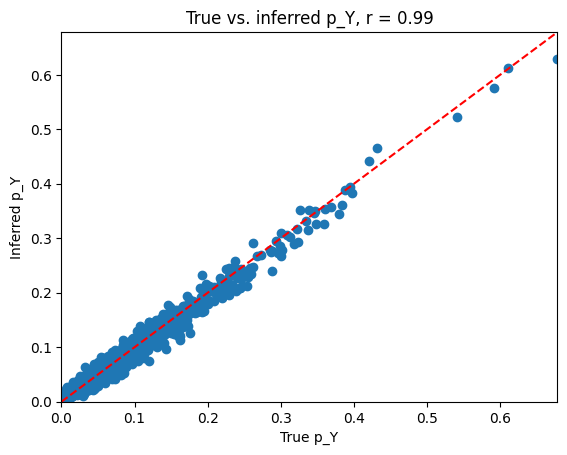

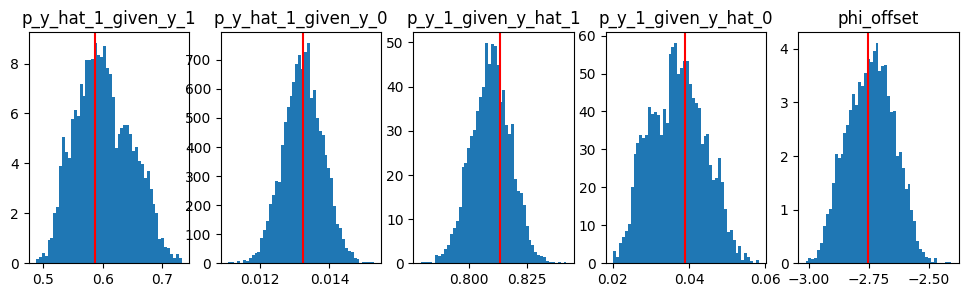

empirical_p_y 0.3111733272582663
empirical_p_yhat 0.16008301259377386
p_y_hat_1_given_y_1 0.48864524743394333
p_y_hat_1_given_y_0 0.011846159676746381
p_y_1_given_y_hat_1 0.9498407421829891
p_y_1_given_y_hat_0 0.18944724556255335
number of annotated classified negative which were positive: 93/500
number of annotated classified positive which were positive: 479/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  28% (3300/12000)
Sampling:  29% (3500/12000)
Sampling:  31% (3700/12000)
Sampling:  32% (3800/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  37% (4400/12000)
Sampling:  38% (4600/12000)
Sampling:  40% (4800/12000)
Sampling:  42% (5000/12000)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.480  0.013   0.456    0.502      0.003    0.002   
p_y_hat_1_given_y_0  0.011  0.002   0.007    0.013      0.000    0.000   
phi_offset          -0.917  0.060  -1.023   -0.798      0.011    0.008   
p_y_1_given_y_hat_1  0.955  0.007   0.942    0.969      0.001    0.000   
p_y_1_given_y_hat_0  0.197  0.011   0.179    0.218      0.002    0.002   
empirical_p_yhat     0.160  0.000   0.160    0.160      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      21.0      67.0   1.13  
p_y_hat_1_given_y_0     215.0     827.0   1.04  
phi_offset               28.0     129.0   1.10  
p_y_1_given_y_hat_1     149.0     659.0   1.04  
p_y_1_given_y_hat_0      20.0      56.0   1.14  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


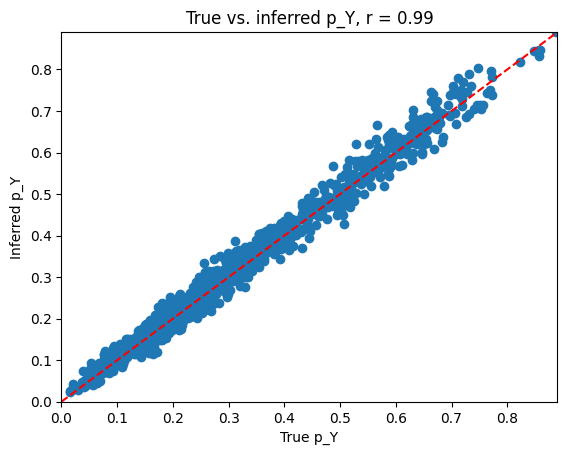

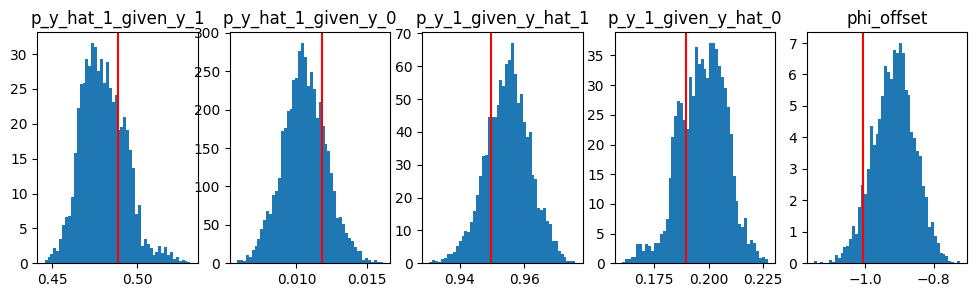

empirical_p_y 0.0641299623660329
empirical_p_yhat 0.026682262364230307
p_y_hat_1_given_y_1 0.22946490868964986
p_y_hat_1_given_y_0 0.01287129771019445
p_y_1_given_y_hat_1 0.5515115531702371
p_y_1_given_y_hat_0 0.05076901868393987
number of annotated classified negative which were positive: 22/500
number of annotated classified positive which were positive: 292/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (401/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2200/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  24% (2900/12000)
Sampling:  26% (3100/12000)
Sampling:  28% (3300/12000)
Sampling:  29% (3500/12000)
Sampling:  31% (3700/12000)
Sampling:  32% (3800/12000)
Sampling:  33% (4000/12000)
Sampling:  35% (4200/12000)
Sampling:  37% (4400/12000)
Sampling:  38% (4600/12000)
Sampling:  41% (4900/12000)
Sampling:  42% (5100/12000)
Sampling:  44% (5300/12000)
Sampling:  46% (5500/12000)
Sampling:  48% (5800/1200

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.266  0.031   0.215    0.327      0.003    0.002   
p_y_hat_1_given_y_0  0.013  0.000   0.012    0.013      0.000    0.000   
phi_offset          -3.242  0.141  -3.512   -2.995      0.015    0.010   
p_y_1_given_y_hat_1  0.557  0.012   0.536    0.581      0.001    0.000   
p_y_1_given_y_hat_0  0.043  0.007   0.030    0.055      0.001    0.001   
empirical_p_yhat     0.027  0.000   0.027    0.027      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      97.0     240.0   1.04  
p_y_hat_1_given_y_0    1108.0    2460.0   1.00  
phi_offset               96.0     243.0   1.04  
p_y_1_given_y_hat_1     339.0    1590.0   1.01  
p_y_1_given_y_hat_0      95.0     229.0   1.04  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


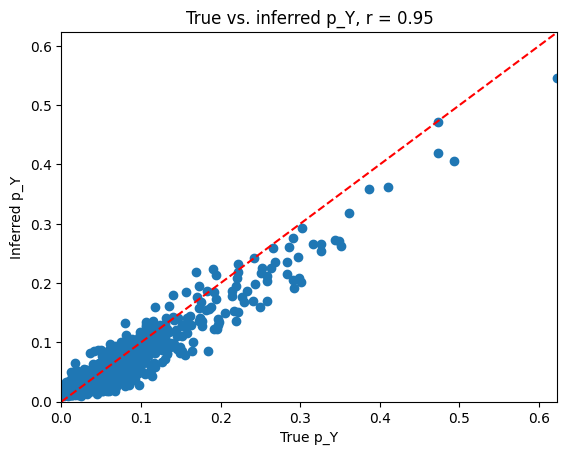

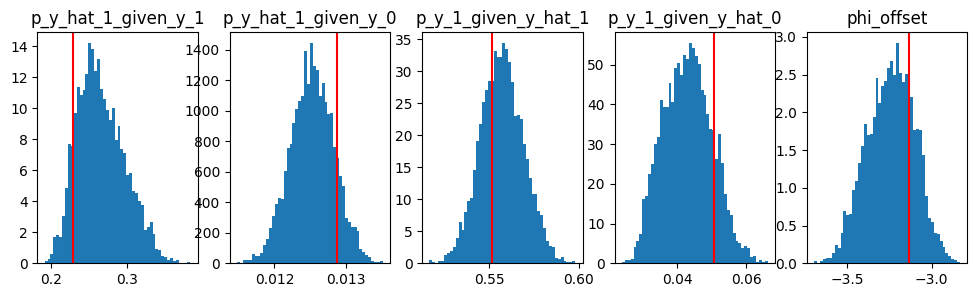

empirical_p_y 0.2487492387431487
empirical_p_yhat 0.10766096894872054
p_y_hat_1_given_y_1 0.3837828978712448
p_y_hat_1_given_y_0 0.016451970801740278
p_y_1_given_y_hat_1 0.8867252879136034
p_y_1_given_y_hat_0 0.17177723905503842
number of annotated classified negative which were positive: 79/500
number of annotated classified positive which were positive: 435/500
Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   3% (302/12000)
Sampling:   4% (501/12000)
Sampling:   6% (700/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1600/12000)
Sampling:  16% (1900/12000)
Sampling:  18% (2100/12000)
Sampling:  20% (2400/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  28% (3300/12000)
Sampling:  29% (3500/12000)
Sampling:  31% (3700/12000)
Sampling:  32% (3900/12000)
Sampling:  34% (4100/12000)
Sampling:  36% (4300/12000)
Sampling:  38% (4500/12000)
Sampling:  39% (4700/12000)
Sampling:  42% (5000/12000)
Sampling:  43% (5200/12000)
Sampling:  45% (5400/12000)
Sampling:  47% (5600/12000)
Sampling:  48% (5800/12000)
Sampling:  51% (6100/12000)
Sampling:  53% (6400/120

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.399  0.014   0.375    0.427      0.002    0.001   
p_y_hat_1_given_y_0  0.018  0.001   0.016    0.021      0.000    0.000   
phi_offset          -1.409  0.065  -1.538   -1.296      0.008    0.006   
p_y_1_given_y_hat_1  0.869  0.009   0.853    0.886      0.001    0.000   
p_y_1_given_y_hat_0  0.158  0.010   0.139    0.175      0.001    0.001   
empirical_p_yhat     0.108  0.000   0.108    0.108      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      58.0      88.0   1.06  
p_y_hat_1_given_y_0     351.0     607.0   1.01  
phi_offset               72.0     141.0   1.04  
p_y_1_given_y_hat_1     199.0     473.0   1.01  
p_y_1_given_y_hat_0      56.0      83.0   1.06  
empirical_p_yhat       4000.0    4000.0    NaN  


/Users/emmapierson/Desktop/my_virtualenvs/new_stan_env2/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


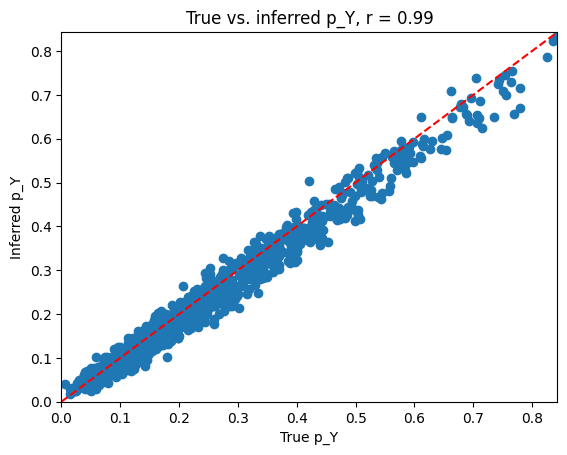

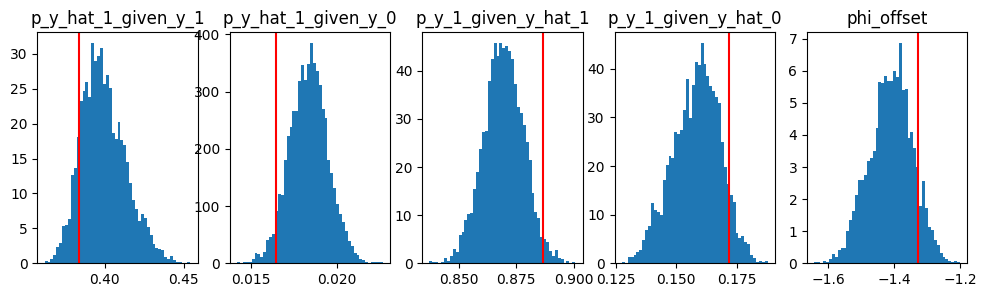

In [11]:
import random
def generate_simulated_data(N, images_per_location, 
                            n_annotated_classified_negative, 
                            n_annotated_classified_positive, 
                            icar_prior_setting):
    """
    Generate simulated data for the model.
    """    
    node1 = []
    node2 = []
    for i in range(N):
        for j in range(i+1, N):
            if np.random.rand() < 0.1:
                node1.append(i + 1) # one indexing for Stan. 
                node2.append(j + 1)
    phi_offset = random.random() * -3 - 1 # mean of phi.

    # these only matter for CAR model. https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
    D = np.zeros((N, N))
    W = np.zeros((N, N))
    for i in range(len(node1)):
        D[node1[i] - 1, node1[i] - 1] += 1
        D[node2[i] - 1, node2[i] - 1] += 1
        W[node1[i] - 1, node2[i] - 1] = 1
        W[node2[i] - 1, node1[i] - 1] = 1
    B = np.linalg.inv(D) @ W
    tau = np.random.gamma(scale=0.2, shape=2)
    alpha = np.random.random()
    sigma = np.linalg.inv(tau * D @ (np.eye(N) - alpha * B))
    if icar_prior_setting != 'none':    
        phi = np.random.multivariate_normal(mean=np.zeros(N), cov=sigma)
    else:
        phi = np.random.normal(loc=0, size=N) # this uses no icar prior, just draws everything independently. 
    p_Y = expit(phi + phi_offset)
    n_images = np.random.poisson(images_per_location, N)
    p_y_hat_1_given_y_1 = random.random() * 0.5 + 0.2
    p_y_hat_1_given_y_0 = random.random() * 0.01 + 0.01

    n_classified_positive = []
    n_true_positive = []
    for i in range(N):
        n_true_positive.append(np.random.binomial(n_images[i], p_Y[i]))
        n_classified_positive.append(np.random.binomial(n_true_positive[-1], p_y_hat_1_given_y_1) + 
                                    np.random.binomial(n_images[i] - n_true_positive[-1], p_y_hat_1_given_y_0))
    empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images)
    empirical_p_y = sum(n_true_positive) * 1.0 / sum(n_images)
    p_y_1_given_y_hat_1 = p_y_hat_1_given_y_1 * empirical_p_y / empirical_p_yhat
    p_y_1_given_y_hat_0 = (1 - p_y_hat_1_given_y_1) * empirical_p_y / (1 - empirical_p_yhat)
    print("empirical_p_y", empirical_p_y)
    print("empirical_p_yhat", empirical_p_yhat)
    print("p_y_hat_1_given_y_1", p_y_hat_1_given_y_1)
    print("p_y_hat_1_given_y_0", p_y_hat_1_given_y_0)
    print("p_y_1_given_y_hat_1", p_y_1_given_y_hat_1)
    print("p_y_1_given_y_hat_0", p_y_1_given_y_hat_0)
                     
    n_annotated_classified_negative_true_positive = np.random.binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0)
    n_annotated_classified_positive_true_positive = np.random.binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1)
    print("number of annotated classified negative which were positive: %i/%i" % (n_annotated_classified_negative_true_positive, n_annotated_classified_negative))
    print("number of annotated classified positive which were positive: %i/%i" % (n_annotated_classified_positive_true_positive, n_annotated_classified_positive))
    

    return {'observed_data':{'N':N, 'N_edges':len(node1), 'node1':node1, 'node2':node2, 
                             'n_images':n_images, 'n_classified_positive':n_classified_positive, 
                             'n_annotated_classified_negative':n_annotated_classified_negative,
                                'n_annotated_classified_positive':n_annotated_classified_positive,
                                'n_annotated_classified_negative_true_positive':n_annotated_classified_negative_true_positive,
                                'n_annotated_classified_positive_true_positive':n_annotated_classified_positive_true_positive},

            'parameters':{'phi':phi, 'phi_offset':phi_offset, 
                          'p_y_1_given_y_hat_1':p_y_1_given_y_hat_1,
                            'p_y_1_given_y_hat_0':p_y_1_given_y_hat_0, 
                            'p_y_hat_1_given_y_1':p_y_hat_1_given_y_1,
                            'p_y_hat_1_given_y_0':p_y_hat_1_given_y_0, 
                            'p_Y':p_Y, 
                            'tau':tau, 'alpha':alpha, 'sigma':sigma}}

icar_prior_setting = 'none'
assert icar_prior_setting in ['none', 'cheating', 'proper']
for i in range(10):
    NUM_WARMUP = 2000
    NUM_SAMPLES = 1000
    N = 1000
    simulated_data = generate_simulated_data(N=N, 
                                                images_per_location=1000, 
                                                n_annotated_classified_negative=500, 
                                                n_annotated_classified_positive=500, 
                                                icar_prior_setting=icar_prior_setting)
    if icar_prior_setting == 'proper':
        raise Exception("Haven't verified that this model actually works! Need to review it / check on simulated data. No need to review the parts which are identical to the other model.")
        W = np.zeros((N, N))
        
        for i in range(len(simulated_data['observed_data']['node1'])):
            W[simulated_data['observed_data']['node1'][i] - 1, 
                                simulated_data['observed_data']['node2'][i] - 1] = 1
            W[simulated_data['observed_data']['node2'][i] - 1, 
                                simulated_data['observed_data']['node1'][i] - 1] = 1
        del simulated_data['observed_data']['node1']
        del simulated_data['observed_data']['node2']
        simulated_data['observed_data']['W'] = W
        simulated_data['observed_data']['W_n'] = int(W.sum() / 2)
        model = stan.build(stan_code_proper_car_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'cheating':
        simulated_data['observed_data']['use_ICAR_prior'] = 1
        simulated_data['observed_data']['ICAR_prior_weight'] = 0.05
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'none':
        simulated_data['observed_data']['use_ICAR_prior'] = 0
        simulated_data['observed_data']['ICAR_prior_weight'] = 0
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=simulated_data['observed_data'])
    else:
        raise ValueError("Invalid icar_prior_options", icar_prior_setting)
    fit = model.sample(num_chains=4, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    print(az.summary(fit, var_names=['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 'phi_offset', 
                                    'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                    'empirical_p_yhat']))

    df = fit.to_frame()

    inferred_p_y = [df[f'p_y.{i}'].mean() for i in range(1, N + 1)]
    plt.scatter(simulated_data['parameters']['p_Y'], inferred_p_y)
    plt.title("True vs. inferred p_Y, r = %.2f" %
            pearsonr(simulated_data['parameters']['p_Y'], inferred_p_y)[0])
    max_val = max(max(simulated_data['parameters']['p_Y']), max(inferred_p_y))
    plt.xlabel("True p_Y")
    plt.ylabel("Inferred p_Y")
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlim([0, max_val])
    plt.ylim([0, max_val])
    plt.figure(figsize=[12, 3])
    if icar_prior_setting == 'proper':
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset', 'alpha', 'tau']
    else:
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset']
    for k in param_names:
        plt.subplot(1, len(param_names), param_names.index(k) + 1)
        # histogram of posterior samples
        plt.hist(df[k], bins=50, density=True)
        plt.title(k)
        plt.axvline(simulated_data['parameters'][k], color='red')
    plt.show()
    #az.plot_trace(fit, var_names=['sigma_Z'])




# Code below here is deprecated. 

In [ ]:
# Stan code below "works" but cheats on the ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all.  
DEPRECATED_stan_code_cheating_ICAR_prior_with_soft_zero_constraint = '''
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real phi_offset; 
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {

  // You can't just scale ICAR priors by random numbers, so this is "cheating". Still, maybe a good sanity check. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // soft sum-to-zero constraint on phi,
  // equivalent to mean(phi) ~ normal(0,0.01)
  phi_offset ~ normal(0, 2);
  //sum(phi) ~ normal(0, 0.01 * N); // ZERO CENTERED.
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''
